# Launch DPS for 3.1.2_dps.py
multi-spectral composites  

##### Notes on DPS processing with this algorithm  
To get a good greenest pixel growing season composite you probably want to:
1. build epochal seasonal composites across 3 seasons (havent looked closely at just 2 seasons yet)
2. specify a cloud cover max of 50%   
    - high (eg 75%) can result in long run times due to 175+ scenes for high lat tiles over 3 seasons. The result - no data void artifacts, but less smooth pixel results.   
    - Compare c2015 (2014-2016 summers; done mostly with 75% CC max thresh) with c2020 (2019-2021 summers; done mostly with 50% CC max thresh)
3. be ready to have your batch of 5000+ tiles NOT process all at once. In fact, processing will be a highly iterative endeavor because EarthData might not like so many requests coming from one source (not sure of this).  
    - MAAP devs looked into this in Fall 2022 and wrote some code with function decorators but this doesnt seem to have solved the problem.
    - MAAP devs can sometimes re-submit the 500 type errors that result - auto-resubmits may solve the problem.
    


In [38]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

In [39]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
!pip install s3fs --upgrade

  Using cached s3fs-2023.1.0-py3-none-any.whl (27 kB)
  Attempting uninstall: s3fs
    Found existing installation: s3fs 0.3.4
    Uninstalling s3fs-0.3.4:
      Successfully uninstalled s3fs-0.3.4
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [40]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install xmltodict

import xmltodict
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils
import matplotlib
import maplib_folium
from folium import TileLayer

  Using cached s3fs-0.3.4-py3-none-any.whl (18 kB)
  Attempting uninstall: s3fs
    Found existing installation: s3fs 2023.1.0
    Uninstalling s3fs-2023.1.0:
      Successfully uninstalled s3fs-2023.1.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [41]:
!python --version

Python 3.7.8


In [5]:
import s3fs
s3fs.__version__

'0.3.4'

## Use the tag set up for this algorithm
#### Commit with Tag for running
1) Add version name as a *tag_name* of `HLS_stack_2022_v2` or whatever is appropriate - both to this notebook and algorithm config yaml

2) follow git instructions (every time!!):  
git add changes  
git commit -m 'message'  
git tag -f `HLS_stack_2022_v2`    

git push  
git push dps  
git push origin -f `HLS_stack_2022_v2`  
git push dps -f `HLS_stack_2022_v2`    

3) if it looks weird check git log to make sure tag is at same place as origin and dps

# Register DPS algorithm
We need to register a DPS algorithm called 'do_HLS_stack_3-1-2' before proceeding to the chunks below...

In [57]:
!python /projects/register-algorithm /projects/Developer/icesat2_boreal/dps/alg_3-1-2/algorithm_config.yaml

{
  "algorithm_name": "do_HLS_stack_3-1-2",
  "code_version": "HLS_stack_2022_v2",
  "environment_name": "ubuntu",
  "repo_url": "https://repo.ops.maap-project.org/icesat2_boreal/icesat2_boreal.git",
  "docker_container_url": "mas.dit.maap-project.org/root/maap-workspaces/base_images/vanilla:dit",
  "queue": "maap-dps-worker-16gb",
  "algorithm_description": "DPS run to create tiled HLS composites",
  "build_command": "icesat2_boreal/dps/build_command_main.sh",
  "script_command": "icesat2_boreal/dps/alg_3-1-2/run.sh",
  "disk_space": "16GB",
  "algorithm_params": [
    {
      "field": "in_tile_fn",
      "download": true
    },
    {
      "field": "in_tile_num",
      "download": false
    },
    {
      "field": "in_tile_layer",
      "download": false
    },
    {
      "field": "sat_api",
      "download": false
    },
    {
      "field": "tile_buffer_m",
      "download": false
    },
    {
      "field": "start_year",
      "download": false
    },
    {
      "field": "end_ye

# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [92]:
RUN_ALL_TILES = False
RUN_IRREGULAR_TILES = True

In [93]:
HLS_TILES_NEEDED = []

if False:
    !python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m_list 03 04 05

# Spring 2022 c2020 composite
HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv' #'/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv'
# Fall 2022 c2020 composite
HLS_EXISTING_TINDEX_FN = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master.csv'
IRREGULAR_TILES_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles.csv'

if RUN_ALL_TILES:
    print('Running DPS on a ALL tiles from a previous tindex')
    hls_tindex_master = pd.read_csv(HLS_EXISTING_TINDEX_FN)
    HLS_TILES_NEEDED = hls_tindex_master.tile_num.to_list()
        
    print(f"List length: {len(HLS_TILES_NEEDED)}")
else:
    if RUN_IRREGULAR_TILES:
        if True:
            # Some additional irregular HLS tiles were found to have produced funky AGB tiles - they should be re-done - forcing to 3000x3000
            #additional_irreg_tiles = [1216, 2375, 3394, 3302, 3117, 3029]
            df = pd.read_csv('/projects/my-public-bucket/DPS_tile_lists/HLS_irregular_tiles_additional.csv')
            additional_irreg_tiles = df.IrregularTiles.to_list()
            HLS_TILES_NEEDED = additional_irreg_tiles
        if False:
            # Original set identified as irregular tiles
            print("Running DPS on irregular tiles that forces a shape of 3000...")
            df = pd.read_csv(IRREGULAR_TILES_FN)
            tile_num_list = []
            for i in df["IrregularTiles"]:
                tile_num = int(i.split('_')[9])
                HLS_TILES_NEEDED.append(tile_num)
    else:
        HLS_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', tindex_master_fn = HLS_EXISTING_TINDEX_FN)
        #HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', FIND_TILE_GROUP = 'north america west', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')

In [97]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)

56

#### Search for tiles that need to be redone due to artifacts
    + artifacts are scene-induced - where max_cloud = 25 was a bit too harsh
    + manually specify a redo tiles list after inspecting MS comps
    + delete the existing tile dirs for those tiles

In [98]:
if not RUN_ALL_TILES and not RUN_IRREGULAR_TILES:
    REDO_TILES = [
                    1043, 1044, \
                    34675, 34674, 34676, 35126, 35125, 35352, 1216,
                    3193, 3286, 3380, 3938, 3949
                 ]

    REDO_TILES = [3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044, 3470]
    # Get the tindex of the REDOs
    redo_hls_tindex = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', REDO_TILES_LIST = REDO_TILES)

    if False:
        # Delete the tile dirs of the tiles needing a REDO
        for file in redo_hls_tindex.local_path.to_list():
            p = os.path.split(file)[0]
            print(p)
            !rm -rf $p
            
    INPUT_TILE_NUM_LIST = REDO_TILES
    print(INPUT_TILE_NUM_LIST)

In [99]:
DO_EXPERIMENT = False

In [100]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [101]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [102]:
# A strip across Siberia that can be improved with shorter seaonal window and broader cloud threshold?
if DO_EXPERIMENT:
    MISC_TILES = []
    INPUT_EXPERIMENT_TILE_NUM_LIST = list(range(1620,1657 + 1))
    print(len(INPUT_EXPERIMENT_TILE_NUM_LIST))

In [103]:
if DICT_RUN_NAME_TIME is None:
    DICT_RUN_NAME_TIME = dict()#.fromkeys([RUN_NAME])
DICT_RUN_NAME_TIME

{'mc50_06-15_09-01_2019_2021': '202302061649'}

# Run a DPS of MS Composite tiles

__Launch dates of HLS relevant satellites:__   

Landsat-8: 2/11/2013  
Sentinel-2 6/23/2015  
Landsat-9 9/27/2021

Various MS composites will be built 

1. a circa 2020 composite (with 2019-2021 data)
2. a circa 2015 composite (with 2014-2016 data) 

__Anticipate Errors:__  
__ERROR__ _No module found: MAAP module_  
`failed\nTraceback (most recent call last):\n  File "/app/icesat2_boreal/dps/alg_3-1-2/../../lib/3.1.2_dps.py", line 17, in <module>\n    from fetch_HLS import get_HLS_data\n  File "/app/icesat2_boreal/lib/fetch_HLS.py", line 14, in <module>\n    from maap.maap import MAAP\nModuleNotFoundError: No module named \'maap\'\n+ cp _stderr.txt _alt_traceback.txt'}}}`

We see this error after Laura has made commits to run some version of our `run_boreal_biomass` class of algorithms.

We use a `tag` so the container should not be changing. 

__FIX:__  re-register the algorithm

__ERROR__ _Bad Gateway_  
`502 Bad Gateway</title></head>\n<body>\n<center><h1>502 Bad Gateway`

For next alg update (per conversation with Sujen Feb 2023):  
1. make changes to alg  
2. test locally  
3. update `dps/alg_3-1-2/build_algorithm.sh` < -- use this instead of the repos build_command.sh : so, in `algorithm_config.yaml` use this file's path
4. create a new tag associated with latest commit (`HLS...v3`), commit, push (see instructions at top here)  
5. re-register the `algorithm_config.yaml`


In [43]:
# Growing season
MAX_CLOUDS = 50 #30
SEASON_START = '06-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'

if False:
    # Late winter
    MAX_CLOUDS = 50
    SEASON_START = '03-15'
    SEASON_STOP = '05-01'
    YEAR_START = '2019'
    YEAR_STOP = '2021'
    RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'

RUN_NAME


'mc30_07-01_09-01_2019_2021'

### Re-run this batch with same tile-specific composite params as spring2022


In [86]:
DO_MATCH_PREVIOUS_PARAMS = False

In [87]:
TEST_DPS  = False

In [119]:
if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[100:200]
else:
    if DO_MATCH_PREVIOUS_PARAMS:
        print('Running DPS on the subset list with matched params')
        OUTPUT_FN = '/projects/my-public-bucket/DPS_tile_lists/HLS/spring2022/HLS_input_params.csv'
        df = pd.read_csv(OUTPUT_FN)
        DPS_INPUT_TILE_NUM_LIST = df[(df.max_cloud == MAX_CLOUDS) & 
                       (df.start_month_day ==SEASON_START) & 
                       (df.end_month_day == SEASON_STOP)
                      ].in_tile_num.to_list()
    elif DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 56


In [44]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS',
                         'shape': 3000
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="HLS_stack_2022_v2", 
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE

    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 1
DPS run #: 1	| tile num: 3301	| submit status: success	| job id: 977cc83c-f9ec-4e2a-8710-78d1171d62db
Current time:	202302101750
CPU times: user 13 ms, sys: 8.22 ms, total: 21.2 ms
Wall time: 330 ms


status  http_status_code                                job_id  dps_num  \
0  success               200  977cc83c-f9ec-4e2a-8710-78d1171d62db        1   

   tile_num                submit_time  dbs_job_hour  \
0      3301 2023-02-10 17:50:52.477199            17   

                     algo_id           user           worker_type  \
0  do_HLS_stack_3-1-2_ubuntu  nathanmthomas  maap-dps-worker-32gb   

                     run_name  
0  mc30_07-01_09-01_2019_2021

After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

#### Update the dict of DPS runs to monitor success and fails

In [45]:
if True:
    DICT_RUN_NAME_TIME = dict()

In [46]:
DICT_RUN_NAME_TIME.update([(RUN_NAME, nowtime)])

In [47]:
for DICT_RUN_NAME, DPS_DATETIME in DICT_RUN_NAME_TIME.items():
    print(DICT_RUN_NAME, DPS_DATETIME)

mc30_07-01_09-01_2019_2021 202302101750


In [48]:
if True:
    IDENTIFIER = "do_HLS_stack_3-1-2"

In [56]:
%%time
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
#for DPS_DATETIME in [nowtime]:
fails_list = []
for DICT_RUN_NAME, DPS_DATETIME in sorted(DICT_RUN_NAME_TIME.items(), reverse=True):
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS run name:\t\t{DICT_RUN_NAME}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')

            # Get current fails df and append to list
            z['run_type'] = DICT_RUN_NAME
            fails_list.append(z[ (z['wps:Status'] != 'Succeeded') & (z['wps:Status'] != 'Running') ] )
            
df_all_fails = pd.concat(fails_list)

DPS alg:		do_HLS_stack_3-1-2
DPS run name:		mc30_07-01_09-01_2019_2021
DPS launch time:	202302101750
Count total jobs:	1
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	1
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

CPU times: user 24.6 ms, sys: 4.82 ms, total: 29.4 ms
Wall time: 1.07 s


### Get a list of the FAILS to run through DPS again
#### Build a dict of the list of fails for each run name

In [26]:
TILE_FAILS_DICT = dict()
for name, group in df_all_fails.groupby('run_name'):
    TILE_FAILS_DICT.update([(name, group.tile_num.to_list())])

In [27]:
#RUN_NAME = 'mc75_06-15_09-01_2014_2016_957fails_858fails'
#RUN_NAME = 'mc50_06-15_09-01_2014_2016_447fails' #_957fails_858fails_786fails'
#RUN_NAME = 'mc50_06-15_09-01_2014_2016_447fails_404fails_336fails_291fails_228fails_149fails'
#RUN_NAME = 'mc25_06-15_09-01_2014_2016_3fails'

In [28]:
DPS_INPUT_TILE_NUM_LIST = TILE_FAILS_DICT[RUN_NAME]

In [29]:
num_fails = len(DPS_INPUT_TILE_NUM_LIST)
RUN_NAME = RUN_NAME + f"_{num_fails}fails"
print(f"Re-try {num_fails}: {RUN_NAME}")

Re-try 1: mc50_06-15_09-01_2019_2021_1fails


In [30]:
print(f"Re-try {num_fails}: {RUN_NAME}")

Re-try 1: mc50_06-15_09-01_2019_2021_1fails


In [31]:
len(DPS_INPUT_TILE_NUM_LIST)

1

In [36]:
DPS_INPUT_TILE_NUM_LIST

[3301]

In [127]:
#DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()#[0:20]
#len(DPS_INPUT_TILE_NUM_LIST)

#pd.DataFrame({'tile_num': DPS_INPUT_TILE_NUM_LIST}).to_csv('/projects/my-public-bucket/dps_submission_results/tmp_tile_list.csv')
#z[z['wps:Status'] =='Failed']

### Look at the error log an an index location of a failed job

In [35]:
INDEX_LOC = 0
#xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[INDEX_LOC].job_id).content)
xmltodict.parse(maap.getJobResult(df_all_fails.iloc[INDEX_LOC].job_id).content)


{'wps:Result': {'@xmlns:ows': 'http://www.opengis.net/ows/2.0',
  '@xmlns:schemaLocation': 'http://schemas.opengis.net/wps/2.0/wps.xsd',
  '@xmlns:wps': 'http://www.opengis.net/wps/2.0',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  'wps:JobID': '53e62a09-2090-497b-b08e-afa711adb9a0',
  'wps:Output': {'@id': 'traceback',
   'wps:Data': '+ /app/icesat2_boreal/dps/alg_3-1-2/run.sh 3301 boreal_tiles_v003 https://cmr.earthdata.nasa.gov/stac/LPCLOUD 0 2019 2021 06-15 09-01 50 HLS 3000\n+ source activate icesat2_boreal\n++ _CONDA_ROOT=/opt/conda\n++ . /opt/conda/etc/profile.d/conda.sh\n+++ export CONDA_EXE=/opt/conda/bin/conda\n+++ CONDA_EXE=/opt/conda/bin/conda\n+++ export _CE_M=\n+++ _CE_M=\n+++ export _CE_CONDA=\n+++ _CE_CONDA=\n+++ export CONDA_PYTHON_EXE=/opt/conda/bin/python\n+++ CONDA_PYTHON_EXE=/opt/conda/bin/python\n+++ \'[\' -z \'\' \']\'\n+++ export CONDA_SHLVL=0\n+++ CONDA_SHLVL=0\n+++ \'[\' -n \'\' \']\'\n+++++ dirname /opt/conda/bin/conda\n++++ dirname /opt/con

### AWS move test files into a test dir

In [95]:
DPS_MONTH = '12'

# This variable should change to a more descriptive "run name" dir after you do an aws s3 mv <from orig dps_output> <to renamed runname dir> --recursive
if TEST_DPS:
    DPS_MONTH_RUNNAME = f"{DPS_MONTH}_test100_{RUN_NAME.replace('mc','')}" #'11_test100_30_06-15_09-01_2014_2016' # 11_test100_
else:
    DPS_MONTH_RUNNAME = DPS_MONTH
    
FROM_DIR = f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2022_v2/2022/{DPS_MONTH}/"
TO_DIR =   f"s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2022_v2/2022/{DPS_MONTH_RUNNAME}/"
DPS_MONTH_RUNNAME

'12'

In [241]:
TO_DIR

's3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/HLS_stack_2022_v2/2022/11_test100_75_06-15_09-01_2014_2016/'

In [ ]:
if TEST_DPS:
    !time aws s3 mv $FROM_DIR $TO_DIR --recursive

### Build a new tindex

In [1]:
MS_COMP_NAME = 'c2020_fix_additional_irregulars'
MAAP_VERSION = "HLS_stack_2022_v2"
DPS_MONTH_LIST = '02'
DPS_DAY_MIN = 1
#OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/HLS/{MS_COMP_NAME}/{MAAP_VERSION}/{DPS_MONTH_RUNNAME}'
OUTDIR = f'/projects/my-public-bucket/DPS_tile_lists/HLS/{MS_COMP_NAME}/{MAAP_VERSION}'

!mkdir -p $OUTDIR
!time python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py --maap_version $MAAP_VERSION -alg_name 'do_HLS_stack_3-1-2_ubuntu' -t 'HLS' -y 2023 --dps_month_list $DPS_MONTH_LIST -d_min $DPS_DAY_MIN --outdir $OUTDIR
#!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -h

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		HLS_stack_2022_v2
Type:		HLS
Year:		2023
Month:		['02']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/HLS/c2020_fix_additional_irregulars/HLS_stack_2022_v2
                                             s3_path  ...                                 file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_34899_06-15_09-01_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_4227_06-15_09-01_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...    HLS_993_06-15_09-01_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_34211_06-15_09-01_2019_2021.tif
4 

### Build mosaic json for mapping in folium

In [8]:
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004,41995,41807,41619]

Building /projects/my-public-bucket/DPS_tile_lists/HLS/c2020latewinter/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json


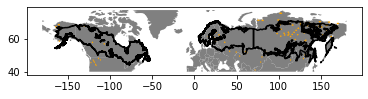

In [9]:
matplotlib.rcParams['figure.figsize'] = [30, 10]
#import importlib
#import ExtractUtils
#importlib.reload(ExtractUtils)

CURRENT_tindex_fn = f'{OUTDIR}/HLS_tindex_master.csv'

HLS_mosaic_json_fn_local, CURRENT_tindex_matches_gdf = ExtractUtils.build_mosaic_json(
                           CURRENT_tindex_fn, 
                           boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg', 
                           BAD_TILE_LIST = BAD_TILE_LIST, 
                           cols_list = ['tile_num','s3_path','local_path'])

HLS_mosaic_json_fn = HLS_mosaic_json_fn_local.replace('/projects/my-public-bucket', 's3://maap-ops-workspace/shared/nathanmthomas')

### Build/write a MScomp input params table

In [10]:
%time
mscomp_params_table_fn = ExtractUtils.write_mscomp_params_table(CURRENT_tindex_fn,  
                                       MSCOMP_TYPE = 'HLS', mscomp_input_glob_str="output*context.json", mscomp_num_scenes_glob_str="master*.json", 
                                       cols_list=['in_tile_num','max_cloud','start_month_day','end_month_day','start_year','end_year'])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
Wrote MS comp HLS params table: /projects/my-public-bucket/DPS_tile_lists/HLS/c2020latewinter/HLS_stack_2022_v2/HLS_input_params.csv


In [11]:
#mscomp_params_table_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv'

### The original spring 2022 HLS comp run types by tile
compositing requires trial and error to return tile composites that are free from cloud and seasonal artifacts  
these "run types" show the final set of compositing params used to return the composites for each tile

In [12]:
# Prep spring2022 HLS input params table - for comparison with current runs
SPRING2022_HLS_input_param_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/spring2022/HLS_input_params.csv'
boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')

SPRING2022_HLS_input_params_df = pd.read_csv(SPRING2022_HLS_input_param_fn)
SPRING2022_HLS_input_params_df['run_type'] = SPRING2022_HLS_input_params_df[['max_cloud','start_month_day','end_month_day','start_year','end_year']].apply(
    lambda x: '_'.join(x.dropna().astype(str)),
    axis=1
)

# Compare CURRENT tile_index_matches_gdf with SPRING2022 params df to get MISSING

CURRENT_MISSING_TILES_GDF = boreal_tile_index[~boreal_tile_index['tile_num'].isin(CURRENT_tindex_matches_gdf.tile_num.to_list())]

CURRENT_MISSING_tindex_HLS_input_params = CURRENT_MISSING_TILES_GDF.merge(SPRING2022_HLS_input_params_df[['in_tile_num','run_type']], how='left', left_on='tile_num', right_on='in_tile_num')
#CURRENT_MISSING_tindex_HLS_input_params.plot(column='run_type', cmap = "nipy_spectral", legend=True)
CURRENT_MISSING_tindex_HLS_input_params.groupby(['run_type']).size()


run_type
10_07-01_09-01_2019_2021     106
25_06-01_09-15_2019_2021    1231
25_06-15_09-01_2019_2021    2222
35_06-15_09-01_2019_2021     914
40_06-01_09-15_2019_2021     257
40_07-01_09-01_2019_2021     134
50_06-01_09-15_2019_2021      19
50_06-15_09-01_2019_2021     261
50_06-15_09-15_2019_2021      12
dtype: int64

### Map missing tiles by run_name

In [6]:
CURRENT_MISSING_tindex_HLS_input_params.fillna('None').info()

NameError: name 'CURRENT_MISSING_tindex_HLS_input_params' is not defined

In [14]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_HLS_input_params.tile_num.to_list()
len(DPS_INPUT_TILE_NUM_LIST)

5248

### Map completed tiles by run_name

AxesSubplot(0.125,0.389335;0.775x0.22633)
AxesSubplot(0.125,0.411968;0.62x0.181064)


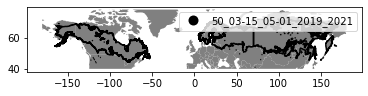

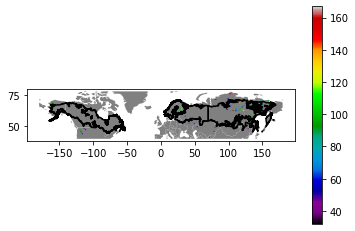

In [15]:
#mscomp_params_table_fn = '/projects/my-public-bucket/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_input_params.csv'

CURRENT_COMPLETE_HLS_input_params_df = pd.read_csv(mscomp_params_table_fn)
CURRENT_COMPLETE_tindex_HLS_input_params = boreal_tile_index.merge(CURRENT_COMPLETE_HLS_input_params_df[['tile_num','run_type','num_scenes']], how='left', left_on='tile_num', right_on='tile_num')
#CURRENT_COMPLETE_tindex_HLS_input_params.plot(column='run_type', cmap = "nipy_spectral", legend=True)
CURRENT_COMPLETE_tindex_HLS_input_params.groupby(['run_type']).size()

ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex_HLS_input_params)
ExtractUtils.plot_gdf_on_world(CURRENT_COMPLETE_tindex_HLS_input_params, MAP_COL="num_scenes")

### Get missing tiles over Land

AxesSubplot(0.125,0.379616;0.775x0.245768)


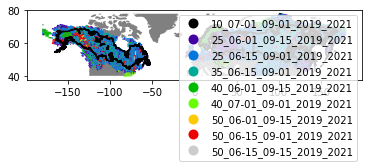

In [16]:
# Use naturalearth to get land
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
world['dissolve_field'] = 'for intersect'
geom_land = world.dissolve(by='dissolve_field').iloc[0].geometry
tmp_gdf = CURRENT_MISSING_tindex_HLS_input_params[~CURRENT_MISSING_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)].to_crs(4326)
selector = tmp_gdf.intersects(geom_land)

CURRENT_MISSING_tindex_LAND = tmp_gdf[selector].to_crs(4326)

ExtractUtils.plot_gdf_on_world(CURRENT_MISSING_tindex_LAND.cx[-180:180, 40:90])

In [17]:
DPS_INPUT_TILE_NUM_LIST = CURRENT_MISSING_tindex_LAND.tile_num.to_list()
len(DPS_INPUT_TILE_NUM_LIST)
#DPS_INPUT_TILE_NUM_LIST

4808

# View the Results with Folium

In [18]:
# Choose various HLS tindex jsons to view
EPOCH = 'c2015' #MS_COMP_NAME
TEST_TINDEX_DIR = 11 #DPS_MONTH_RUNNAME #'11_test100_50_06-15_09-01_2014_2016' #DPS_MONTH_RUNNAME
HLS_mosaic_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/{EPOCH}/HLS_stack_2022_v2/{TEST_TINDEX_DIR}/HLS_tindex_master_mosaic.json'
HLS_mosaic_json_fn

's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2015/HLS_stack_2022_v2/11/HLS_tindex_master_mosaic.json'

In [ ]:
import importlib

importlib.reload(maplib_folium)

# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

MS_BANDNAME = 'NBR2'
MS_BANDMIN=0.25
MS_BANDMAX=0.45 
MS_BANDNUM=13 
MS_BANDCOLORBAR='nipy_spectral'

HLS_mosaic_fall2022_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'
HLS_mosaic_fall2022_FIX_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/fall2022_fix_irregulars/HLS_stack_2022_v2/12/HLS_tindex_master_mosaic.json'

# Final HLS comp for c2020
HLS_mosaic_c2020_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

# Final HLS comp for c2015
HLS_mosaic_c2015_json_fn = f's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2015/HLS_stack_2022_v2/11/HLS_tindex_master_mosaic.json' 

# Test of HLS comp for late winter
HLS_mosaic_c2020latewinter_json_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS/c2020latewinter/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json'

mscomp_fall2022_FIX_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_fall2022_FIX_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="fixed tiles HLS comp",
            attr="MAAP",
            overlay=True
        )

mscomp_c2020_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2020_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="final c2020 HLS comp",
            attr="MAAP",
            overlay=True
        )

mscomp_c2015_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2015_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="final c2015 HLS comp",
            attr="MAAP",
            overlay=True
        )

mscomp_c2020latewinter_tiles_layer = TileLayer(
            tiles= f"{tiler_mosaic}?url={HLS_mosaic_c2020latewinter_json_fn}&rescale={MS_BANDMIN},{MS_BANDMAX}&bidx={MS_BANDNUM}&colormap_name={MS_BANDCOLORBAR}",
            opacity=1,
            name="Late Winter c2020 HLS comp",
            attr="MAAP",
            overlay=True
        )

# Dict for specifying a different MS comp band to map
MS_BAND_DICT = {
    'name': MS_BANDNAME,
    'min' : MS_BANDMIN ,
    'max' : MS_BANDMAX , 
    'num' : MS_BANDNUM, 
    'cmap' : MS_BANDCOLORBAR,
    'legend_name': MS_BANDNAME + ' from HLS'
}

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              CURRENT_COMPLETE_tindex_HLS_input_params[~CURRENT_COMPLETE_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], #boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_index_matches_gdf.tile_num.to_list())], 
                              CURRENT_MISSING_tindex_HLS_input_params[~CURRENT_MISSING_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], #boreal_tile_index[boreal_tile_index['tile_num'].isin([4441])], 
                              MATCH_TILES_NAME='Current complete tiles',
                              CHECK_TILES_NAME='Current missing tiles',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_fall2022_json_fn, 
                                        #'mscomp_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/DPS_tile_lists/HLS/fall2022/HLS_stack_2022_v2/HLS_tindex_master_mosaic.json',
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },

                            MS_BAND_DICT=MS_BAND_DICT,
                            map_width=1500, map_height=750,
                            ADD_TILELAYER = {
                                                "layer": mscomp_c2015_tiles_layer, #mscomp_c2020latewinter_tiles_layer
                                                "cmap": MS_BANDCOLORBAR,
                                                "max_val": MS_BANDMAX,
                                                "caption": MS_BANDNAME + ' from HLS c.2015'
                                            }
                             )

In [ ]:
# Setup the mosaic tiling
tiler_base = "https://jqsd6bqdsf.execute-api.us-west-2.amazonaws.com/" #titiler.maap-project.org
tiler_mosaic =  "".join([tiler_base, "mosaicjson/tiles/{z}/{x}/{y}"])

boreal_tile_index = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
Topo_mosaic_json_fn  = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master_mosaic.json'

maplib_folium.MAP_DPS_RESULTS(tiler_mosaic, 
                              boreal_tile_index[~boreal_tile_index['tile_num'].isin(BAD_TILE_LIST)], #bad_tiles 
                              CURRENT_COMPLETE_tindex_HLS_input_params[~CURRENT_COMPLETE_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], #boreal_tile_index[boreal_tile_index['tile_num'].isin(tile_index_matches_gdf.tile_num.to_list())], 
                              CURRENT_MISSING_tindex_HLS_input_params[~CURRENT_MISSING_tindex_HLS_input_params['tile_num'].isin(BAD_TILE_LIST)], #boreal_tile_index[boreal_tile_index['tile_num'].isin([4441])], 
                              MATCH_TILES_NAME='Current complete tiles',
                              CHECK_TILES_NAME='Current missing tiles',
                              mosaic_json_dict = 
                                  {     ######### PRODUCT LAYERS #######
                                        #---NASA ABoVE Aboveground Boreal Woody Biomass Density
                                        'agb_mosaic_json_s3_fn': None, # AGB_mosaic_json_fn,                                                           # < -- v. spring 2022 - bad overviews, but faster
                                        #'agb_mosaic_json_s3_fn': 's3://maap-ops-workspace/shared/nathanthomas/06/AGB_tindex_master_mosaic.json',# < -- v. summer 2022 - locally corrected overviews
                                        'topo_mosaic_json_s3_fn':   Topo_mosaic_json_fn,
                                        #'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn_spring2022, 
                                        'mscomp_mosaic_json_s3_fn': HLS_mosaic_json_fn,
                                        'worldcover_json_s3_fn': None,
                                        'tp_standage2020_json_s3_fn': None,
                                        'tp_tcc2020_json_s3_fn': None,
                                        'tp_tcc2020slope_json_s3_fn': None,
                                        'tp_tcc2020pvalue_json_s3_fn': None 
                                     },
                             #mscomp_rgb_dict = None,
                            MS_BANDNAME = 'Year',
                            MS_BANDMIN=2014,
                            MS_BANDMAX=2017, #1.1,
                            MS_BANDNUM=21, #9,
                            MS_BANDCOLORBAR='tab20b',
                            
                              map_width=1500, map_height=750
                             )

In [980]:
#importlib.reload(maplib_folium)
maplib_folium.map_tile_n_scenes(tindex_master_fn=mscomp_params_table_fn, max_n_obs=200, map_width=1500, map_height=500)

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


### Examine a tile locally (download from s3)

In [51]:
TILE_NUM = 2899
s3_fn = CURRENT_tindex_matches_gdf[CURRENT_tindex_matches_gdf.tile_num == TILE_NUM].s3_path.to_list()[0]
local_fn = '/projects/test_data/'+os.path.basename(s3_fn)

s3 = s3fs.S3FileSystem(anon=True)
s3.download(s3_fn, local_fn)

In [ ]:
CURRENT_tindex_matches_gdf.head()